# Convolution Nets for MNIST

Deep Learning models can take quite a bit of time to run, particularly if GPU isn't used. 

In the interest of time, you could sample a subset of observations (e.g. $1000$) that are a particular number of your choice (e.g. $6$) and $1000$ observations that aren't that particular number (i.e. $\neq 6$). 

We will build a model using that and see how it performs on the test dataset

In [1]:
#Import the required libraries
import numpy as np
np.random.seed(1338)

from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

In [3]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

In [4]:
from keras.utils import np_utils
from keras.optimizers import SGD

## Loading Data

In [5]:
#Load the training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
X_test_orig = X_test

## Data Preparation

### Very Important: 
When dealing with images & convolutions, it is paramount to handle `image_data_format` properly

In [7]:
from keras import backend as K

In [8]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

#### Preprocess and Normalise Data

In [9]:
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [10]:
np.random.seed(1338)  # for reproducibilty!!

# Test data
X_test = X_test.copy()
Y = y_test.copy()

# Converting the output to binary classification(Six=1,Not Six=0)
Y_test = Y == 6
Y_test = Y_test.astype(int)

# Selecting the 5918 examples where the output is 6
X_six = X_train[y_train == 6].copy()
Y_six = y_train[y_train == 6].copy()

# Selecting the examples where the output is not 6
X_not_six = X_train[y_train != 6].copy()
Y_not_six = y_train[y_train != 6].copy()

# Selecting 6000 random examples from the data that 
# only contains the data where the output is not 6
random_rows = np.random.randint(0,X_six.shape[0],6000)
X_not_six = X_not_six[random_rows]
Y_not_six = Y_not_six[random_rows]

In [11]:
# Appending the data with output as 6 and data with output as <> 6
X_train = np.append(X_six,X_not_six)

# Reshaping the appended data to appropraite form
X_train = X_train.reshape((X_six.shape[0] + X_not_six.shape[0],) + shape_ord)

# Appending the labels and converting the labels to 
# binary classification(Six=1,Not Six=0)
Y_labels = np.append(Y_six,Y_not_six)
Y_train = Y_labels == 6 
Y_train = Y_train.astype(int)

In [12]:
print(X_train.shape, Y_labels.shape, X_test.shape, Y_test.shape)

(11918, 28, 28, 1) (11918,) (10000, 28, 28, 1) (10000,)


In [13]:
# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

# A simple CNN

In [14]:
# -- Initializing the values for the convolution neural network

nb_epoch = 2  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

#### Step 1: Model Definition

In [15]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

#### Step 2: Compile

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#### Step 3: Fit

In [17]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 8s - loss: 0.2321 - acc: 0.9491 - val_loss: 0.1276 - val_acc: 0.9616
Epoch 2/2
11918/11918 [==============================] - 1s - loss: 0.1065 - acc: 0.9666 - val_loss: 0.0933 - val_acc: 0.9685


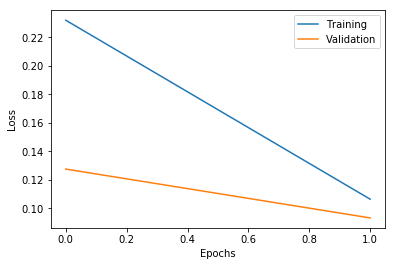

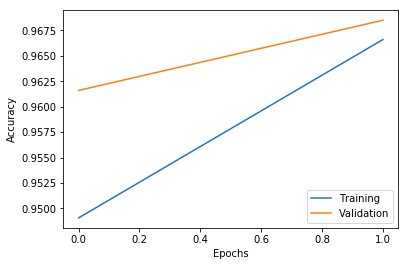

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

### Step 4: Evaluate

In [19]:
print('Available Metrics in Model: {}'.format(model.metrics_names))

Available Metrics in Model: ['loss', 'acc']


In [20]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.0933376350194
Test Accuracy: 0.9685


### Let's plot our model Predictions!

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

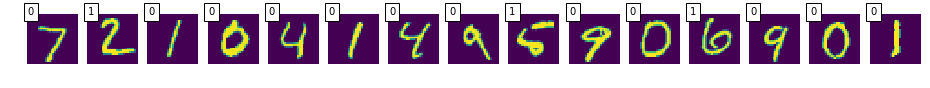

In [22]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

# Adding more Dense Layers

In [23]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 2s - loss: 0.1922 - acc: 0.9503 - val_loss: 0.0864 - val_acc: 0.9721
Epoch 2/2
11918/11918 [==============================] - 1s - loss: 0.0902 - acc: 0.9705 - val_loss: 0.0898 - val_acc: 0.9676


In [25]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0898462146357
Test accuracy: 0.9676


# Adding Dropout

In [26]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                        padding='valid',
                        input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 1s - loss: 0.2394 - acc: 0.9330 - val_loss: 0.1882 - val_acc: 0.9355
Epoch 2/2
11918/11918 [==============================] - 1s - loss: 0.1038 - acc: 0.9654 - val_loss: 0.0900 - val_acc: 0.9679


In [28]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0900323278204
Test accuracy: 0.9679


# Adding more Convolution Layers

In [29]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 2s - loss: 0.3680 - acc: 0.8722 - val_loss: 0.1699 - val_acc: 0.9457
Epoch 2/2
11918/11918 [==============================] - 2s - loss: 0.1380 - acc: 0.9508 - val_loss: 0.0600 - val_acc: 0.9793


In [31]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0600312609494
Test accuracy: 0.9793


# Exercise

The above code has been written as a function. 

Change some of the **hyperparameters** and see what happens. 

In [32]:
# Function for constructing the convolution neural network
# Feel free to add parameters, if you want

def build_model():
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, Y_test))
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)

In [33]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model()

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 2s - loss: 0.3752 - acc: 0.8672 - val_loss: 0.1512 - val_acc: 0.9505
Epoch 2/2
11918/11918 [==============================] - 2s - loss: 0.1384 - acc: 0.9528 - val_loss: 0.0672 - val_acc: 0.9775
Test score: 0.0671689324878
Test accuracy: 0.9775
5.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


---

## Understanding Convolutional Layers Structure

In this exercise we want to build a (_quite shallow_) network which contains two 
[Convolution, Convolution, MaxPooling] stages, and two Dense layers.

To test a different optimizer, we will use [AdaDelta](http://keras.io/optimizers/), which is a bit more complex than the simple Vanilla SGD with momentum.

In [35]:
from keras.optimizers import Adadelta

In [36]:
input_shape = shape_ord
nb_classes = 10

## [conv@32x3x3+relu]x2 --> MaxPool@2x2 --> DropOut@0.25 -->
## [conv@64x3x3+relu]x2 --> MaxPool@2x2 --> DropOut@0.25 -->
## Flatten--> FC@512+relu --> DropOut@0.5 --> FC@nb_classes+SoftMax
## NOTE: each couple of Conv filters must have `border_mode="same"` and `"valid"`, respectively

In [40]:
# %load solutions/sol31.py

### Understanding layer shapes

An important feature of Keras layers is that each of them has an `input_shape` attribute, which you can use to visualize the shape of the input tensor, and an `output_shape` attribute, for inspecting the shape of the output tensor.

As we can see, the input shape of the first convolutional layer corresponds to the `input_shape` attribute (which must be specified by the user). 

In this case, it is a `28x28` image with three color channels. 

Since this convolutional layer has the `padding` set to `same`, its output width and height will remain the same, and the number of output channel will be equal to the number of filters learned by the layer, 16. 

The following convolutional layer, instead, have the default `padding`, and therefore reduce width and height by $(k-1)$, where $k$ is the size of the kernel. 

`MaxPooling` layers, instead, reduce width and height of the input tensor, but keep the same number of channels. 

`Activation` layers, of course, don't change the shape.

In [42]:
for i, layer in enumerate(model.layers):
    print ("Layer", i, "\t", layer.name, "\t\t", layer.input_shape, "\t", layer.output_shape)

Layer 0 	 conv2d_12 		 (None, 28, 28, 1) 	 (None, 28, 28, 32)
Layer 1 	 activation_21 		 (None, 28, 28, 32) 	 (None, 28, 28, 32)
Layer 2 	 conv2d_13 		 (None, 28, 28, 32) 	 (None, 26, 26, 32)
Layer 3 	 activation_22 		 (None, 26, 26, 32) 	 (None, 26, 26, 32)
Layer 4 	 max_pooling2d_5 		 (None, 26, 26, 32) 	 (None, 13, 13, 32)
Layer 5 	 dropout_6 		 (None, 13, 13, 32) 	 (None, 13, 13, 32)
Layer 6 	 conv2d_14 		 (None, 13, 13, 32) 	 (None, 13, 13, 64)
Layer 7 	 activation_23 		 (None, 13, 13, 64) 	 (None, 13, 13, 64)
Layer 8 	 conv2d_15 		 (None, 13, 13, 64) 	 (None, 11, 11, 64)
Layer 9 	 activation_24 		 (None, 11, 11, 64) 	 (None, 11, 11, 64)
Layer 10 	 max_pooling2d_6 		 (None, 11, 11, 64) 	 (None, 5, 5, 64)
Layer 11 	 dropout_7 		 (None, 5, 5, 64) 	 (None, 5, 5, 64)
Layer 12 	 flatten_6 		 (None, 5, 5, 64) 	 (None, 1600)
Layer 13 	 dense_10 		 (None, 1600) 	 (None, 512)
Layer 14 	 activation_25 		 (None, 512) 	 (None, 512)
Layer 15 	 dropout_8 		 (None, 512) 	 (None, 512)
Layer 16 	 

### Understanding weights shape

In the same way, we can visualize the shape of the weights learned by each layer. 

In particular, Keras lets you inspect weights by using the `get_weights` method of a layer object. 

This will return a list with two elements, the first one being the **weight tensor** and the second one being the **bias vector**.

In particular:

- **MaxPooling layer** don't have any weight tensor, since they don't have learnable parameters. 


- **Convolutional layers**, instead, learn a $(n_o, n_i, k, k)$ weight tensor, where $k$ is the size of the kernel, $n_i$ is the number of channels of the input tensor, and $n_o$ is the number of filters to be learned. 

For each of the $n_o$ filters, a bias is also learned. 


- **Dense layers** learn a $(n_i, n_o)$ weight tensor, where $n_o$ is the output size and $n_i$ is the input size of the layer. Each of the $n_o$ neurons also has a bias.

In [45]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Layer", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)

Layer 0 	 conv2d_12 		 (3, 3, 1, 32) 	 (32,)
Layer 2 	 conv2d_13 		 (3, 3, 32, 32) 	 (32,)
Layer 6 	 conv2d_14 		 (3, 3, 32, 64) 	 (64,)
Layer 8 	 conv2d_15 		 (3, 3, 64, 64) 	 (64,)
Layer 13 	 dense_10 		 (1600, 512) 	 (512,)
Layer 16 	 dense_11 		 (512, 10) 	 (10,)


# Batch Normalisation

Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

## How to BatchNorm in Keras

```python
from keras.layers.normalization import BatchNormalization

BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                   beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                   moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                   beta_constraint=None, gamma_constraint=None)
```

#### Arguments

<ul>
<li><strong>axis</strong>: Integer, the axis that should be normalized
    (typically the features axis).
    For instance, after a <code>Conv2D</code> layer with
    <code>data_format="channels_first"</code>,
    set <code>axis=1</code> in <code>BatchNormalization</code>.</li>
<li><strong>momentum</strong>: Momentum for the moving average.</li>
<li><strong>epsilon</strong>: Small float added to variance to avoid dividing by zero.</li>
<li><strong>center</strong>: If True, add offset of <code>beta</code> to normalized tensor.
    If False, <code>beta</code> is ignored.</li>
<li><strong>scale</strong>: If True, multiply by <code>gamma</code>.
    If False, <code>gamma</code> is not used.
    When the next layer is linear (also e.g. <code>nn.relu</code>),
    this can be disabled since the scaling
    will be done by the next layer.</li>
<li><strong>beta_initializer</strong>: Initializer for the beta weight.</li>
<li><strong>gamma_initializer</strong>: Initializer for the gamma weight.</li>
<li><strong>moving_mean_initializer</strong>: Initializer for the moving mean.</li>
<li><strong>moving_variance_initializer</strong>: Initializer for the moving variance.</li>
<li><strong>beta_regularizer</strong>: Optional regularizer for the beta weight.</li>
<li><strong>gamma_regularizer</strong>: Optional regularizer for the gamma weight.</li>
<li><strong>beta_constraint</strong>: Optional constraint for the beta weight.</li>
<li><strong>gamma_constraint</strong>: Optional constraint for the gamma weight.</li>
</ul>

### Excercise

In [34]:
# Try to add a new BatchNormalization layer to the Model 
# (after the Dropout layer) - before or after the ReLU Activation

---

## Addendum:

* [CNN on CIFAR10](4.3 CIFAR10 CNN.ipynb)